<a href="https://colab.research.google.com/github/mhisle22/Data-Science-Projects/blob/master/dsc305_lab05_hisle_mark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mark Hisle  
Carson Anderson  
DSC 305A S20  
Lab 5: Guess the Goalkeeper  


**Import the [FIFA 19 complete player dataset](https://www.kaggle.com/karangadiya/fifa19) dataset from Kaggle.**

*The data set was scraped from [sofifa.com](https://sofifa.com/), which seems to draw its data from the EA FIFA 19 game, which in turn is modeled on real-world FIFA data.  (We would have used the more recent FIFA 20 dataset, but it is missing some vital data that we need for Part A.)*

*For each problem (Parts A, B, C, and D), follow the usual steps: explore the data set, prepare the data for modeling, explore models (e.g., with grid search and cross-validation) and choose the  best-performing model, evaluate your model, and analyze your results.  Any preliminary work that is for more than one part should be placed before the Part A heading.  Organize your work using appropriate subheadings.  Remember that you are telling a story, and that this notebook is both your solution and your written and visual presentation of your work.  Good luck!*  

In [0]:
import numpy as np
import pandas as pd
from sklearn import metrics #for visualization
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import random
import itertools

%matplotlib inline

#Data Observation

In [0]:
fifa = pd.read_csv("data.csv")
pd.set_option('display.max_columns', None) #necessary to handle huge amount of columns
fifa

,Unnamed: 0,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,Club Logo,Value,Wage,Special,Preferred Foot,International Reputation,Weak Foot,Skill Moves,Work Rate,Body Type,Real Face,Position,Jersey Number,Joined,Loaned From,Contract Valid Until,Height,Weight,LS,ST,RS,LW,LF,CF,RF,RW,LAM,CAM,RAM,LM,LCM,CM,RCM,RM,LWB,LDM,CDM,RDM,RWB,LB,LCB,CB,RCB,RB,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,0,158023,L. Messi,31,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,94,94,FC Barcelona,https://cdn.sofifa.org/teams/2/light/241.png,€110.5M,€565K,2202,Left,5.0,4.0,4.0,Medium/ Medium,Messi,Yes,RF,10.0,"Jul 1, 2004",NaN,2021,5'7,159lbs,88+2,88+2,88+2,92+2,93+2,93+2,93+2,92+2,93+2,93+2,93+2,91+2,84+2,84+2,84+2,91+2,64+2,61+2,61+2,61+2,64+2,59+2,47+2,47+2,47+2,59+2,84.0,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,91.0,86.0,91.0,95.0,95.0,85.0,68.0,72.0,59.0,94.0,48.0,22.0,94.0,94.0,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,1,20801,Cristiano Ronaldo,33,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Juventus,https://cdn.sofifa.org/teams/2/light/45.png,€77M,€405K,2228,Right,5.0,4.0,5.0,High/ Low,C. Ronaldo,Yes,ST,7.0,"Jul 10, 2018",NaN,2022,6'2,183lbs,91+3,91+3,91+3,89+3,90+3,90+3,90+3,89+3,88+3,88+3,88+3,88+3,81+3,81+3,81+3,88+3,65+3,61+3,61+3,61+3,65+3,61+3,53+3,53+3,53+3,61+3,84.0,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,89.0,91.0,87.0,96.0,70.0,95.0,95.0,88.0,79.0,93.0,63.0,29.0,95.0,82.0,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,2,190871,Neymar Jr,26,https://cdn.sofifa.org/players/4/19/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,93,Paris Saint-Germain,https://cdn.sofifa.org/teams/2/light/73.png,€118.5M,€290K,2143,Right,5.0,5.0,5.0,High/ Medium,Neymar,Yes,LW,10.0,"Aug 3, 2017",NaN,2022,5'9,150lbs,84+3,84+3,84+3,89+3,89+3,89+3,89+3,89+3,89+3,89+3,89+3,88+3,81+3,81+3,81+3,88+3,65+3,60+3,60+3,60+3,65+3,60+3,47+3,47+3,47+3,60+3,79.0,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,94.0,90.0,96.0,94.0,84.0,80.0,61.0,81.0,49.0,82.0,56.0,36.0,89.0,87.0,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,3,193080,De Gea,27,https://cdn.sofifa.org/players/4/19/193080.png,Spain,https://cdn.sofifa.org/flags/45.png,91,93,Manchester United,https://cdn.sofifa.org/teams/2/light/11.png,€72M,€260K,1471,Right,4.0,3.0,1.0,Medium/ Medium,Lean,Yes,GK,1.0,"Jul 1, 2011",NaN,2020,6'4,168lbs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.0,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,57.0,58.0,60.0,90.0,43.0,31.0,67.0,43.0,64.0,12.0,38.0,30.0,12.0,68.0,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,4,192985,K. De Bruyne,27,https://cdn.sofifa.org/players/4/19/192985.png,Belgium,https://cdn.sofifa.org/flags/7.png,91,92,Manchester City,https://cdn.sofifa.org/teams/2/light/10.png,€102M,€355K,2281,Right,4.0,5.0,4.0,High/ High,Normal,Yes,RCM,7.0,"Aug 30, 2015",NaN,2023,5'11,154lbs,82+3,82+3,82+3,87+3,87+3,87+3,87+3,87+3,88+3,88+3,88+3,88+3,87+3,87+3,87+3,88+3,77+3,77+3,77+3,77+3,77+3,73+3,66+3,66+3,66+3,73+3,93.0,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,78.0,76.0,79.0,91.0,77.0,91.0,63.0,90.0,75.0,91.0,76.0,61.0,87.0,94.0,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

Right of the bat, we know that there is an enormous amount of data here, and it is clear that not all of it is valid either. Because this size of data would slow down the rest of our modeling process, we need to exclude columns that will not provide us with any help, along with dropping rows that have missing data in necessary columns.

In [0]:
fifa.isna().any()
fifaCount = fifa.count()
fifaCount.head(50)
#fifaCount.tail(50)

Unnamed: 0                  18207
ID                          18207
Name                        18207
Age                         18207
Photo                       18207
Nationality                 18207
Flag                        18207
Overall                     18207
Potential                   18207
Club                        17966
Club Logo                   18207
Value                       18207
Wage                        18207
Special                     18207
Preferred Foot              18159
International Reputation    18159
Weak Foot                   18159
Skill Moves                 18159
Work Rate                   18159
Body Type                   18159
Real Face                   18159
Position                    18147
Jersey Number               18147
Joined                      16654
Loaned From                  1264
Contract Valid Until        17918
Height                      18159
Weight                      18159
LS                          16122
ST            

There is a lot unpack here, but we can make a few important observations from viewing the data and its counts:

* Some missing data, but everyone has general identification data
* Some dont have positions
* loan data is basically useless to us, a few others are like this
* keepers are missing data for non-keeper positions and vice versa
  * seems like groups of 2000-ish are missing from a few columns, which is around the number of keepers
* some people dont have release clauses, some havent joined teams
* body type might not be useful
* many columns do not have useful data
* a few columns will be useful but need their data to be converted into numerical data  

Below are the columns we will keep, as they hold data we find to be helpful to our desired models. Many of the original columns hold data that could be used and potentially help our models, but for the most part seem insignificant or too arduous to convert to a useful form for their yielded benefit.  
  
Useful columns & necessary operations
* age
* overall
* potential
* value (convert to number)
* wage (convert to number)
* Preferred foot (encode)
* international reputation
* weak foot
* skill moves
* work rate (split into 2 columns, then encode those columns)
* position (one-hot encode)
* height (convert to number)
* weight (convert to number)
* Crossing-GKReflexed (34)
* release clause (convert to number)  
  
We are left with 34+14=48 variables, a few of which will be converted via one-hot encode. Although still large, this is much more manageable than before, especially since we will be adding new ones.

In [0]:
fifa2 = fifa.drop(columns=['Unnamed: 0', 'ID', 'Name', 'Photo', 'Nationality', 'Flag', 'Club', 'Club Logo',
                          'Special', 'Body Type', 'Real Face', 'Jersey Number', 'Joined', 'Loaned From',
                          'Contract Valid Until', 'LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW', 'LAM',
                          'CAM', 'RAM', 'LM', 'LCM', 'CM', 'RCM', 'RM', 'LWB', 'LDM', 'CDM', 'RDM',
                          'RWB', 'LB', 'LCB', 'CB', 'RCB', 'RB'])
fifa2

,Age,Overall,Potential,Value,Wage,Preferred Foot,International Reputation,Weak Foot,Skill Moves,Work Rate,Position,Height,Weight,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,31,94,94,€110.5M,€565K,Left,5.0,4.0,4.0,Medium/ Medium,RF,5'7,159lbs,84.0,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,91.0,86.0,91.0,95.0,95.0,85.0,68.0,72.0,59.0,94.0,48.0,22.0,94.0,94.0,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,33,94,94,€77M,€405K,Right,5.0,4.0,5.0,High/ Low,ST,6'2,183lbs,84.0,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,89.0,91.0,87.0,96.0,70.0,95.0,95.0,88.0,79.0,93.0,63.0,29.0,95.0,82.0,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,26,92,93,€118.5M,€290K,Right,5.0,5.0,5.0,High/ Medium,LW,5'9,150lbs,79.0,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,94.0,90.0,96.0,94.0,84.0,80.0,61.0,81.0,49.0,82.0,56.0,36.0,89.0,87.0,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,27,91,93,€72M,€260K,Right,4.0,3.0,1.0,Medium/ Medium,GK,6'4,168lbs,17.0,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,57.0,58.0,60.0,90.0,43.0,31.0,67.0,43.0,64.0,12.0,38.0,30.0,12.0,68.0,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,27,91,92,€102M,€355K,Right,4.0,5.0,4.0,High/ High,RCM,5'11,154lbs,93.0,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,78.0,76.0,79.0,91.0,77.0,91.0,63.0,90.0,75.0,91.0,76.0,61.0,87.0,94.0,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18202,19,47,65,€60K,€1K,Right,1.0,2.0,2.0,Medium/ Medium,CM,5'9,134lbs,34.0,38.0,40.0,49.0,25.0,42.0,30.0,34.0,45.0,43.0,54.0,57.0,60.0,49.0,76.0,43.0,55.0,40.0,47.0,38.0,46.0,46.0,39.0,52.0,43.0,45.0,40.0,48.0,47.0,10.0,13.0,7.0,8.0,9.0,€143K
18203,19,47,63,€60K,€1K,Right,1.0,2.0,2.0,Medium/ Medium,ST,6'3,170lbs,23.0,52.0,52.0,43.0,36.0,39.0,32.0,20.0,25.0,40.0,41.0,39.0,38.0,40.0,52.0,41.0,47.0,43.0,67.0,42.0,47.0,16.0,46.0,33.0,43.0,42.0,22.0,15.0,19.0,10.0,9.0,9.0,5.0,12.0,€113K
18204,16,47,67,€60K,€1K,Right,1.0,3.0,2.0,Medium/ Medium,ST,5'8,148lbs,25.0,40.0,46.0,38.0,38.0,45.0,38.0,27.0,28.0,44.0,70.0,69.0,50.0,47.0,58.0,45.0,60.0,55.0,32.0,45.0,32.0,15.0,48.0,43.0,55.0,41.0,32.0,13.0,11.0,6.0,5.0,10.0,6.0,13.0,€165K
18205,17,47,66,€60K,€1K,Right,1.0,3.0,2.0,Medium/ Medium,RW,5'10,154lbs,44.0,50.0,39.0,42.0,40.0,51.0,34.0,32.0,32.0,52.0,61.0,60.0,52.0,21.0,71.0,64.0,42.0,40.0,48.0,34.0,33.0,22.0,44.0,47.0,50.0,46.0,20.0,25.0,27.0,14.0,6.0,14.0,8.0,9.0,€143K


For the most part, many of the above variables were dropped as they are not useful to model building or do not come in a uniform format (like body type). We made two noteworthy choices here on variables that could potentially be useful but were not logical to add:
* Player Club was dropped as it would provide far too many one-hot encoded binary variables if transformed. Our motivation here came in the idea of the curse of dimensionality- we believe that although this variable may prove to be useful, the sheer number of extra variables it would add would nullify any benefit it may have provided
* The group of variables determining player skill at different positions was dropped as it provided only a small amount of useful data for each player at the cost of having many more dependent variables. Because the overall variable and the other skill-based variables largely cover this concept, we decided not to include these

#Data Preparation

In [0]:
duplicates = fifa2[fifa2.duplicated(keep='last')]
fifa2 = fifa2.drop(duplicates.index)

As always, drop any duplicate data.

In [0]:
#remove any nulls in the columns we want to keep
fifa2 = fifa2.dropna(subset=['Overall','Value','Wage','Height', 'Weight', 'Release Clause'])
fifa2

,Age,Overall,Potential,Value,Wage,Preferred Foot,International Reputation,Weak Foot,Skill Moves,Work Rate,Position,Height,Weight,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,31,94,94,€110.5M,€565K,Left,5.0,4.0,4.0,Medium/ Medium,RF,5'7,159lbs,84.0,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,91.0,86.0,91.0,95.0,95.0,85.0,68.0,72.0,59.0,94.0,48.0,22.0,94.0,94.0,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,33,94,94,€77M,€405K,Right,5.0,4.0,5.0,High/ Low,ST,6'2,183lbs,84.0,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,89.0,91.0,87.0,96.0,70.0,95.0,95.0,88.0,79.0,93.0,63.0,29.0,95.0,82.0,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,26,92,93,€118.5M,€290K,Right,5.0,5.0,5.0,High/ Medium,LW,5'9,150lbs,79.0,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,94.0,90.0,96.0,94.0,84.0,80.0,61.0,81.0,49.0,82.0,56.0,36.0,89.0,87.0,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,27,91,93,€72M,€260K,Right,4.0,3.0,1.0,Medium/ Medium,GK,6'4,168lbs,17.0,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,57.0,58.0,60.0,90.0,43.0,31.0,67.0,43.0,64.0,12.0,38.0,30.0,12.0,68.0,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,27,91,92,€102M,€355K,Right,4.0,5.0,4.0,High/ High,RCM,5'11,154lbs,93.0,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,78.0,76.0,79.0,91.0,77.0,91.0,63.0,90.0,75.0,91.0,76.0,61.0,87.0,94.0,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18202,19,47,65,€60K,€1K,Right,1.0,2.0,2.0,Medium/ Medium,CM,5'9,134lbs,34.0,38.0,40.0,49.0,25.0,42.0,30.0,34.0,45.0,43.0,54.0,57.0,60.0,49.0,76.0,43.0,55.0,40.0,47.0,38.0,46.0,46.0,39.0,52.0,43.0,45.0,40.0,48.0,47.0,10.0,13.0,7.0,8.0,9.0,€143K
18203,19,47,63,€60K,€1K,Right,1.0,2.0,2.0,Medium/ Medium,ST,6'3,170lbs,23.0,52.0,52.0,43.0,36.0,39.0,32.0,20.0,25.0,40.0,41.0,39.0,38.0,40.0,52.0,41.0,47.0,43.0,67.0,42.0,47.0,16.0,46.0,33.0,43.0,42.0,22.0,15.0,19.0,10.0,9.0,9.0,5.0,12.0,€113K
18204,16,47,67,€60K,€1K,Right,1.0,3.0,2.0,Medium/ Medium,ST,5'8,148lbs,25.0,40.0,46.0,38.0,38.0,45.0,38.0,27.0,28.0,44.0,70.0,69.0,50.0,47.0,58.0,45.0,60.0,55.0,32.0,45.0,32.0,15.0,48.0,43.0,55.0,41.0,32.0,13.0,11.0,6.0,5.0,10.0,6.0,13.0,€165K
18205,17,47,66,€60K,€1K,Right,1.0,3.0,2.0,Medium/ Medium,RW,5'10,154lbs,44.0,50.0,39.0,42.0,40.0,51.0,34.0,32.0,32.0,52.0,61.0,60.0,52.0,21.0,71.0,64.0,42.0,40.0,48.0,34.0,33.0,22.0,44.0,47.0,50.0,46.0,20.0,25.0,27.0,14.0,6.0,14.0,8.0,9.0,€143K


A few players appear to not have important values (overall, age, etc.) that make them unusable by our models- we dropped these.

In [0]:
#function to convert height in current format to only inches
def convertHeight(ht):
    htSplit = ht.split("'")
    ft = int(htSplit[0])
    inches = int(htSplit[1])
    return (ft*12) + inches

#function to convert money strings to numerical data
def convertMoney(t):
    m = t[len(t)-1]
    t = t[1:len(t)-1]
    if m == 'M':
        return float(t) * 1000000
    if m == 'K':
        return float(t) * 1000

#convert columns
fifa2["Height"] = fifa2["Height"].apply(lambda x:convertHeight(x))

fifa2['Weight'] = fifa2['Weight'].str.replace('lbs', '')

fifa2['Wage'] = fifa2["Wage"].apply(lambda x:convertMoney(x))
fifa2['Value'] = fifa2["Value"].apply(lambda x:convertMoney(x))
fifa2['Release Clause'] = fifa2["Release Clause"].apply(lambda x:convertMoney(x))

#fix the work rate column by splitting it and adding two new ones
fifa2[['OffenseWorkRate','DefenseWorkRate']] = fifa2['Work Rate'].str.split("/",expand=True,)
fifa2 = fifa2.drop(columns=["Work Rate"])
fifa2

,Age,Overall,Potential,Value,Wage,Preferred Foot,International Reputation,Weak Foot,Skill Moves,Position,Height,Weight,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause,OffenseWorkRate,DefenseWorkRate
0,31,94,94,110500000.0,565000.0,Left,5.0,4.0,4.0,RF,67,159,84.0,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,91.0,86.0,91.0,95.0,95.0,85.0,68.0,72.0,59.0,94.0,48.0,22.0,94.0,94.0,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,226500000.0,Medium,Medium
1,33,94,94,77000000.0,405000.0,Right,5.0,4.0,5.0,ST,74,183,84.0,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,89.0,91.0,87.0,96.0,70.0,95.0,95.0,88.0,79.0,93.0,63.0,29.0,95.0,82.0,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,127100000.0,High,Low
2,26,92,93,118500000.0,290000.0,Right,5.0,5.0,5.0,LW,69,150,79.0,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,94.0,90.0,96.0,94.0,84.0,80.0,61.0,81.0,49.0,82.0,56.0,36.0,89.0,87.0,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,228100000.0,High,Medium
3,27,91,93,72000000.0,260000.0,Right,4.0,3.0,1.0,GK,76,168,17.0,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,57.0,58.0,60.0,90.0,43.0,31.0,67.0,43.0,64.0,12.0,38.0,30.0,12.0,68.0,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,138600000.0,Medium,Medium
4,27,91,92,102000000.0,355000.0,Right,4.0,5.0,4.0,RCM,71,154,93.0,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,78.0,76.0,79.0,91.0,77.0,91.0,63.0,90.0,75.0,91.0,76.0,61.0,87.0,94.0,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,196400000.0,High,High
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18202,19,47,65,60000.0,1000.0,Right,1.0,2.0,2.0,CM,69,134,34.0,38.0,40.0,49.0,25.0,42.0,30.0,34.0,45.0,43.0,54.0,57.0,60.0,49.0,76.0,43.0,55.0,40.0,47.0,38.0,46.0,46.0,39.0,52.0,43.0,45.0,40.0,48.0,47.0,10.0,13.0,7.0,8.0,9.0,143000.0,Medium,Medium
18203,19,47,63,60000.0,1000.0,Right,1.0,2.0,2.0,ST,75,170,23.0,52.0,52.0,43.0,36.0,39.0,32.0,20.0,25.0,40.0,41.0,39.0,38.0,40.0,52.0,41.0,47.0,43.0,67.0,42.0,47.0,16.0,46.0,33.0,43.0,42.0,22.0,15.0,19.0,10.0,9.0,9.0,5.0,12.0,113000.0,Medium,Medium
18204,16,47,67,60000.0,1000.0,Right,1.0,3.0,2.0,ST,68,148,25.0,40.0,46.0,38.0,38.0,45.0,38.0,27.0,28.0,44.0,70.0,69.0,50.0,47.0,58.0,45.0,60.0,55.0,32.0,45.0,32.0,15.0,48.0,43.0,55.0,41.0,32.0,13.0,11.0,6.0,5.0,10.0,6.0,13.0,165000.0,Medium,Medium
18205,17,47,66,60000.0,1000.0,Right,1.0,3.0,2.0,RW,70,154,44.0,50.0,39.0,42.0,40.0,51.0,34.0,32.0,32.0,52.0,61.0,60.0,52.0,21.0,71.0,64.0,42.0,40.0,48.0,34.0,33.0,22.0,44.0,47.0,50.0,46.0,20.0,25.0,27.0,14.0,6.0,14.0,8.0,9.0,143000.0,Medium,Medium


Above we convert a few columns into numerical data and split Work Rate into two so that we can use this data for our model.

In [0]:
backup_fifa = fifa2 #see part d
fifa2 = pd.get_dummies(fifa2, columns=['Preferred Foot', 'Position', 'OffenseWorkRate', 'DefenseWorkRate'])
fifa2

,Age,Overall,Potential,Value,Wage,International Reputation,Weak Foot,Skill Moves,Height,Weight,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause,Preferred Foot_Left,Preferred Foot_Right,Position_CAM,Position_CB,Position_CDM,Position_CF,Position_CM,Position_GK,Position_LAM,Position_LB,Position_LCB,Position_LCM,Position_LDM,Position_LF,Position_LM,Position_LS,Position_LW,Position_LWB,Position_RAM,Position_RB,Position_RCB,Position_RCM,Position_RDM,Position_RF,Position_RM,Position_RS,Position_RW,Position_RWB,Position_ST,OffenseWorkRate_High,OffenseWorkRate_Low,OffenseWorkRate_Medium,DefenseWorkRate_ High,DefenseWorkRate_ Low,DefenseWorkRate_ Medium
0,31,94,94,110500000.0,565000.0,5.0,4.0,4.0,67,159,84.0,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,91.0,86.0,91.0,95.0,95.0,85.0,68.0,72.0,59.0,94.0,48.0,22.0,94.0,94.0,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,226500000.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1
1,33,94,94,77000000.0,405000.0,5.0,4.0,5.0,74,183,84.0,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,89.0,91.0,87.0,96.0,70.0,95.0,95.0,88.0,79.0,93.0,63.0,29.0,95.0,82.0,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,127100000.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0
2,26,92,93,118500000.0,290000.0,5.0,5.0,5.0,69,150,79.0,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,94.0,90.0,96.0,94.0,84.0,80.0,61.0,81.0,49.0,82.0,56.0,36.0,89.0,87.0,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,228100000.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
3,27,91,93,72000000.0,260000.0,4.0,3.0,1.0,76,168,17.0,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,57.0,58.0,60.0,90.0,43.0,31.0,67.0,43.0,64.0,12.0,38.0,30.0,12.0,68.0,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,138600000.0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
4,27,91,92,102000000.0,355000.0,4.0,5.0,4.0,71,154,93.0,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,78.0,76.0,79.0,91.0,77.0,91.0,63.0,90.0,75.0,91.0,76.0,61.0,87.0,94.0,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,196400000.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18202,19,47,65,60000.0,1000.0,1.0,2.0,2.0,69,134,34.0,38.0,40.0,49.0,25.0,42.0,30.0,34.0,45.0,43.0,54.0,57.0,60.0,49.0,76.0,43.0,55.0,40.0,47.0,38.0,46.0,46.0,39.0,52.0,43.0,45.0,40.0,48.0,47.0,10.0,13.0,7.0,8.0,9.0,143000.0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
18203,19,47,63,60000.0,1000.0,1.0,2.0,2.0,75,170,23.0,52.0,52.0,43.0,36.0,39.0,32.0,20.0,25.0,40.0,41.0,39.0,38.0,40.0,52.0,41.0,47.0,43.0,67.0,42.0,47.0,16.0,46.0,33.0,43.0,42.0,22.0,15.0,19.0,10.0,9.0,9.0,5.0,12.0,113000.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1
18204,16,47,67,60000.0,1000.0,1.0,3.0,2.0,68,148,25.0,40.0,46.0,38.0,38.0,45.0,38.0,27.0,28.0,44.0,70.0,69.0,50.0,47.0,58.0,45.0,60.0,55.0,32.0,45.0,32.0,15.0,48.0,43.0,55.0,41.0,32.0,13.0,11.0,6.0,5.0,10.0,6.0,13.0,165000.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1
18205,17,47,66,60000.0,1000.0,1.0,3.0,2.0,70,154,44.0,50.0,39.0,42.0,40.0,51.0,34.0,32.0,32.0,52.0,61.0,60.0,52.0,21.0,71.0,64.0,42.0,40.0,48.0,34.0,33.0,22.0,44.0,47.0,50.0,46.0,20.0,25.0,27.0,14.0,6.0,14.0,8.0,9.0,143000.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1


Above we one-hot encode categorical data using pandas' get_dummies function.

## Part A: Predict the market value and wage of each player

*First, see if you can use the data about each player to predict their (2019) market value and wage (in Euros).  As usual, you should explore the dataset with respect to this particular problem.  Choose your features carefully.  For example, several columns (e.g., `player_url`) are equivalent to an index.  (I suppose you could train your model on the name "Cristiano Ronaldo" if you like, but that is unlikely to generalize to your test set!)*

In [0]:
X = fifa2.loc[:, fifa2.columns != 'Value']
y = fifa2['Value']
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size=0.20,
                                                   random_state=0)

Business as usual here- isolate the Value column to be our dependent variable.

In [0]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Scale the data as usual for efficiency.

In [0]:
lm = LinearRegression()

lm.fit(X_train, y_train)
print(lm.score(X_train, y_train))
print(lm.score(X_test, y_test))

0.9903980302498773
0.9891264257570115


It appears that this linear regression model is quite accurrate for predicting the value of players. This largely makes sense- the FIFA game developers would naturally make a more valuable player more talented in game, thus having their variables match up to their value quite well. Thus, we have a highly accurate (99%) model for predicting player value.

In [0]:
X = fifa2.loc[:, fifa2.columns != 'Wage']
y = fifa2['Wage']
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size=0.20,
                                                   random_state=0)

In [0]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [0]:
lm = LinearRegression()

lm.fit(X_train, y_train)
print(lm.score(X_train, y_train))
print(lm.score(X_test, y_test))

0.7745641076017881
0.7512258610536484


Unlike value, wage appears to have more variability and is more difficult to predict. This would be due to a variety of real-world factors that determine wage, such as the wealth of their club

## Part B: Identify the preferred foot (right or left) for each player

*Predict from the data whether the player prefers to use the right or the left foot (similar to right- or left-handedness).  Note that we would not expect such a dataset to be balanced with respect to class labels.*

In [0]:
fifa3 = fifa2.drop(columns=['Preferred Foot_Left'])
fifa3

,Age,Overall,Potential,Value,Wage,International Reputation,Weak Foot,Skill Moves,Height,Weight,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause,Preferred Foot_Right,Position_CAM,Position_CB,Position_CDM,Position_CF,Position_CM,Position_GK,Position_LAM,Position_LB,Position_LCB,Position_LCM,Position_LDM,Position_LF,Position_LM,Position_LS,Position_LW,Position_LWB,Position_RAM,Position_RB,Position_RCB,Position_RCM,Position_RDM,Position_RF,Position_RM,Position_RS,Position_RW,Position_RWB,Position_ST,OffenseWorkRate_High,OffenseWorkRate_Low,OffenseWorkRate_Medium,DefenseWorkRate_ High,DefenseWorkRate_ Low,DefenseWorkRate_ Medium
0,31,94,94,110500000.0,565000.0,5.0,4.0,4.0,67,159,84.0,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,91.0,86.0,91.0,95.0,95.0,85.0,68.0,72.0,59.0,94.0,48.0,22.0,94.0,94.0,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,226500000.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1
1,33,94,94,77000000.0,405000.0,5.0,4.0,5.0,74,183,84.0,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,89.0,91.0,87.0,96.0,70.0,95.0,95.0,88.0,79.0,93.0,63.0,29.0,95.0,82.0,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,127100000.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0
2,26,92,93,118500000.0,290000.0,5.0,5.0,5.0,69,150,79.0,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,94.0,90.0,96.0,94.0,84.0,80.0,61.0,81.0,49.0,82.0,56.0,36.0,89.0,87.0,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,228100000.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
3,27,91,93,72000000.0,260000.0,4.0,3.0,1.0,76,168,17.0,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,57.0,58.0,60.0,90.0,43.0,31.0,67.0,43.0,64.0,12.0,38.0,30.0,12.0,68.0,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,138600000.0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
4,27,91,92,102000000.0,355000.0,4.0,5.0,4.0,71,154,93.0,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,78.0,76.0,79.0,91.0,77.0,91.0,63.0,90.0,75.0,91.0,76.0,61.0,87.0,94.0,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,196400000.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18202,19,47,65,60000.0,1000.0,1.0,2.0,2.0,69,134,34.0,38.0,40.0,49.0,25.0,42.0,30.0,34.0,45.0,43.0,54.0,57.0,60.0,49.0,76.0,43.0,55.0,40.0,47.0,38.0,46.0,46.0,39.0,52.0,43.0,45.0,40.0,48.0,47.0,10.0,13.0,7.0,8.0,9.0,143000.0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
18203,19,47,63,60000.0,1000.0,1.0,2.0,2.0,75,170,23.0,52.0,52.0,43.0,36.0,39.0,32.0,20.0,25.0,40.0,41.0,39.0,38.0,40.0,52.0,41.0,47.0,43.0,67.0,42.0,47.0,16.0,46.0,33.0,43.0,42.0,22.0,15.0,19.0,10.0,9.0,9.0,5.0,12.0,113000.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1
18204,16,47,67,60000.0,1000.0,1.0,3.0,2.0,68,148,25.0,40.0,46.0,38.0,38.0,45.0,38.0,27.0,28.0,44.0,70.0,69.0,50.0,47.0,58.0,45.0,60.0,55.0,32.0,45.0,32.0,15.0,48.0,43.0,55.0,41.0,32.0,13.0,11.0,6.0,5.0,10.0,6.0,13.0,165000.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1
18205,17,47,66,60000.0,1000.0,1.0,3.0,2.0,70,154,44.0,50.0,39.0,42.0,40.0,51.0,34.0,32.0,32.0,52.0,61.0,60.0,52.0,21.0,71.0,64.0,42.0,40.0,48.0,34.0,33.0,22.0,44.0,47.0,50.0,46.0,20.0,25.0,27.0,14.0,6.0,14.0,8.0,9.0,143000.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1


Lucky for us, one-hot encoding the preferred foot variable already binarized this data piece, so we only need to drop one of the two encodes.

In [0]:
X = fifa3.loc[:, fifa3.columns != 'Preferred Foot_Right']
y = fifa3['Preferred Foot_Right']
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size=0.80,
                                                   stratify=y, #there aren't too many lefties
                                                   random_state=0)

In [0]:
distribution = [np.sum([y_test == y]) for y in [0,1]]
distribution

[3056, 10259]

Above we split the data into two sets as usual and check distribution. It is important to note that there are much more right-footed players than left-footed. We should keep this in mind moving forward.

In [0]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [0]:
model = LogisticRegression(solver='lbfgs', 
                           multi_class='multinomial', 
                           C=1.0,
                           random_state=0,
                           max_iter=1500)
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1500,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
model.score(X_train, y_train)

0.8440504807692307

In [0]:
y_predict = model.predict(X_test)
model.score(X_test, y_test)

0.8301915133308299

After scaling the data and training our model, we have produced a model with an effectiveness of 84%. This is a mediocre resulte, but we should look into the results further to ensure that nothing is wrong.

In [0]:
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.77      0.37      0.50      3056
           1       0.84      0.97      0.90     10259

    accuracy                           0.83     13315
   macro avg       0.80      0.67      0.70     13315
weighted avg       0.82      0.83      0.81     13315



Clearly there is a discrepancy between the results for the two classes- the confusion matrix will help us understand this further.

Text(0.5, 257.44, 'Predicted label')

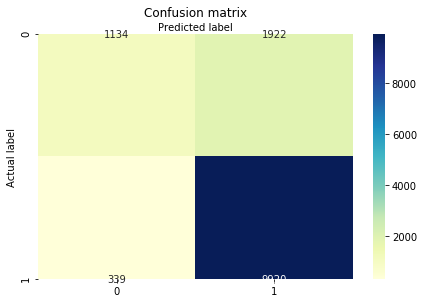

In [0]:
#visualization of confusion matrix
cnf_matrix = confusion_matrix(y_test, y_predict)

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap, confusion matrix calculated above
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

Like we predicted before, it appears that the low number of left-footed players has substantially affected our model. Because most players in the training set would be right-footed (as in real life), our model will naturally tend to lean towards estimating that most players are right-footed. 

Our model is quite good at predicting a player as right-footed when they are truly right-footed. However, it is important to note that the model guesses players to right-footed the vast majority of the time. On the other hand, our model is quite bad at determining a left-footed player, and was wrong more times than correct. This is not surprising, as the model will tend to guess right-footed due to its frequency in the data.

In addition to this issue of the data itself, it is not entirely clear how one would determine the preferred foot of a player with the data given. In the real world, left-footed players do not have certain disadvantages or advantages in comparsion to right-footed platers that are caused by their foot preferrence. Because of this, one could make the claim that the accuracy in our model only comes from the fact that so many players are right footed, making it easier to guess correctly.

It is difficult to find a way to improve this issue, as the real world has few left-footed players in comparison to right-footed players. Because of this, we would recommend a new approach to this issue using a different method, or would conclude that this problem does not present itself well to prediction due to the nature of the data.

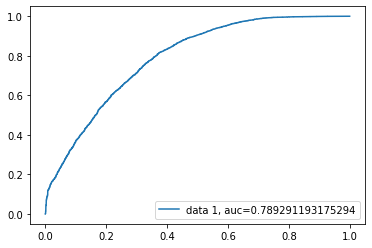

In [0]:
#AUC curve
y_pred_proba = model.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

Once again, the curvature of our ROC curve for this model shows its shortcomings quite well.

From here on, we will attempt to use hyperparameter tuning and cross-validation set splits to attempt to find a better model.

In [0]:
C = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
solver = ['lbfgs', 'sag', 'saga', 'newton-cg']
param_grid = dict(C=C,
                  solver=solver)

grid = GridSearchCV(estimator=LogisticRegression(multi_class='multinomial', random_state=0,max_iter=1500),
                    param_grid=param_grid, #use above hyperparameters
                    scoring='roc_auc',
                    verbose=1, #print what's going on
                    n_jobs=-1, #-1: train in parallel
                    cv=4) #number of cross-validation splits
grid_result = grid.fit(X_train, y_train)

print('Best Score: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)
#print(grid_result.score(X_train, y_train))

Fitting 4 folds for each of 32 candidates, totalling 128 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:   36.9s finished


Best Score:  0.8004651599676553
Best Params:  {'C': 1.0, 'solver': 'sag'}


In [0]:
print(grid_result.score(X_train, y_train))

0.8290501384453284


It does not seem that any different hyperparameters than the one used above (C=1, solver=lfbgs) yielded better results than what we had previously done. 

Further testing below shows this to be true.

In [0]:
y_predict = grid_result.predict(X_test)
grid_result.score(X_test, y_test)

0.7892878759500661

In [0]:
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.77      0.37      0.50      3056
           1       0.84      0.97      0.90     10259

    accuracy                           0.83     13315
   macro avg       0.80      0.67      0.70     13315
weighted avg       0.82      0.83      0.81     13315



Text(0.5, 257.44, 'Predicted label')

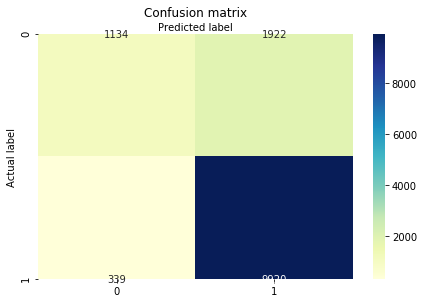

In [0]:
cnf_matrix = confusion_matrix(y_test, y_predict)

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap, confusion matrix calculated above
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

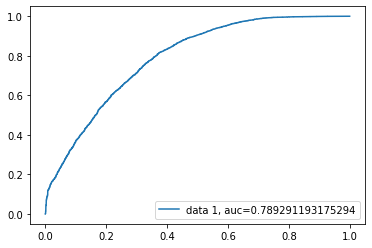

In [0]:
#AUC curve
y_pred_proba = model.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

## Part C: Predict the goalkeepers

*It should be easy to identify the goalkeeper, right?  Or at least it should be no more difficult than identifying the positions of other players, as we attempt in the next step.  So let's start with that.*

*Again, explore the data and choose your features with care.  There are several columns that **only** or **never** apply to goalkeepers (look for N/A values).  You should **not** include those in your features $X$!*

*Note: Although it would be very rare to find a goalkeeper who plays other positions, I think  the rules do allow that, even in the same match.  You should thus examine the data to see whether this ever occurs.  If you do find a goalkeeper who also plays other positions, then it is up to you how to handle that anomaly&mdash;just be sure to document how you handle it, as you would any similarly unusual situation.*  

In [0]:
#note, we are back to fifa2 since we need preferred foot back to a one-hot encode var
X = fifa2.loc[:, fifa2.columns != 'Position_GK']
y = fifa2['Position_GK']
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size=0.80,
                                                   stratify=y, #gk's are only a few of total
                                                   random_state=0)


In [0]:
distribution = [np.sum([y_test == y]) for y in [0,1]]
distribution

[11795, 1520]

Somewhat similarly to before, we have run into the event where there are very few keepers in comparison to every other plater. This once again makes sense- keeper is only one position, and it is a somewhat less popular position at that. However, unlike before, keepers have substantial differences in their attributes in comparison to other players. The fact that their skill attributes are almost completely different than that of other players (i.e.- goalkeepers have a Reflex attribute, GKreflexes, that will be substantially higher than a non-goalkeeper) will likely aid in the classifying of players.

In [0]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [0]:
model = LogisticRegression(solver='lbfgs', 
                           multi_class='multinomial', 
                           C=1.0,
                           random_state=0,
                           max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
model.score(X_train, y_train)

1.0

In [0]:
y_predict = model.predict(X_test)
model.score(X_test, y_test)

1.0

After building our model, we have achieved an accuracy of 100%. As discussed above, the uniqueness of goalkeepers in comparison to other positions suggests that this problem could indeed be linearly separable. However, we should further analyze our model before drawing conclusions.

In [0]:
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11795
           1       1.00      1.00      1.00      1520

    accuracy                           1.00     13315
   macro avg       1.00      1.00      1.00     13315
weighted avg       1.00      1.00      1.00     13315



Text(0.5, 257.44, 'Predicted label')

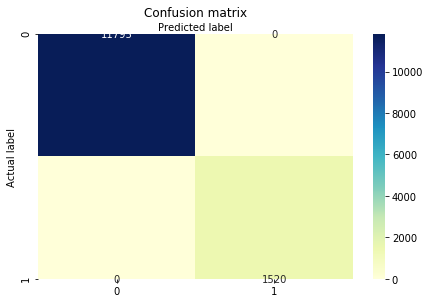

In [0]:
cnf_matrix = confusion_matrix(y_test, y_predict)

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap, confusion matrix calculated above
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

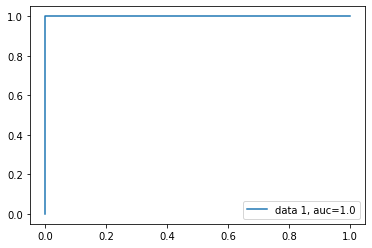

In [0]:
#AUC curve
y_pred_proba = model.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

From the two visualizations above, we have evidence to support that this data is linearly separable. The fact that the attributes of the two classes are quite different coupled with the fact that their are few keepers as a percentage of all players leads one to believe that these results are accurate.

## Part D: Identify the positions of the other players

*Next, build a model that identifies the most likely positions of* **every** *player based on the data available to you.  This will require some creativity since many players play more than one position.  You will need to think carefully about how to model the problem so that you can report* **all** *likely positions for each player, not just the* **most** *likely position.*

In [0]:
fifa = pd.get_dummies(backup_fifa, columns=['Preferred Foot', 'OffenseWorkRate', 'DefenseWorkRate'])

In [0]:
X = fifa.loc[:, fifa.columns != 'Position']
y = fifa['Position']
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size=0.20,
                                                   random_state=0)

Naturally we will want to isolate position so it can be used as the dependent variable. Certain variables have also been reset so that they can be used in this model.

In [0]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [0]:
model = LogisticRegression(solver='lbfgs', 
                           multi_class='multinomial', 
                           C=1.0,
                           random_state=0,
                           max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
model.score(X_train, y_train)

0.602899203845576

In [0]:
y_predict = model.predict(X_test)
model.score(X_test, y_test)

0.6067888254731151

It appears that our model is not very accurate at predicting position. There are many different positions for it to guess, and not all positions are easilt identifiable like keeper. 

In [0]:
"""C = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
solver = ['lbfgs', 'sag', 'saga', 'newton-cg']
param_grid = dict(C=C,
                  solver=solver)

grid = GridSearchCV(estimator=LogisticRegression(solver='lbfgs', multi_class='multinomial', random_state=0,max_iter=1500),
                    param_grid=param_grid, #use above hyperparameters
                    scoring='roc_auc',
                    verbose=1, #print what's going on
                    n_jobs=-1, #-1: train in parallel
                    cv=4) #number of cross-validation splits
grid_result = grid.fit(X_train, y_train)

print('Best Score: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)"""

"C = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]\nsolver = ['lbfgs', 'sag', 'saga', 'newton-cg']\nparam_grid = dict(C=C,\n                  solver=solver)\n\ngrid = GridSearchCV(estimator=LogisticRegression(solver='lbfgs', multi_class='multinomial', random_state=0,max_iter=1500),\n                    param_grid=param_grid, #use above hyperparameters\n                    scoring='roc_auc',\n                    verbose=1, #print what's going on\n                    n_jobs=-1, #-1: train in parallel\n                    cv=4) #number of cross-validation splits\ngrid_result = grid.fit(X_train, y_train)\n\nprint('Best Score: ', grid_result.best_score_)\nprint('Best Params: ', grid_result.best_params_)"

In [0]:
# repurposed code from the guide listed below for multiclass logistic regression
# https://acadgild.com/blog/logistic-regression-multiclass-classification
count_misclassified = (y_test != y_predict).sum()
print('Misclassified samples: {}'.format(count_misclassified))
accuracy = metrics.accuracy_score(y_test, y_predict)
print('Accuracy: {:.2f}'.format(accuracy))

Misclassified samples: 1309
Accuracy: 0.61


It is not surprising that this is not a highly accurate model. Although we made a model that can determine an indivdual position with keeper, this does not mean that all positions are easily identifiable. Not only do other positions not have the advantage of having wholy unique stats, many of them can be very hard to discern as they are somewhat interchangeable. For example, although a striker (forward) and a center back (defense) can have quite large differences, a left back does not have fundamental skill differences in comparison to a right back. Wages and salary also can vary substantially, as they are based more on overall skill than position.

It may be possible to instead find a model that can predict the position of a player in more vague terms. For exampe, it would be much easier to predict between forward, midfield, defense, and keeper, as these three groups of positions have noticeable differences. However, the similarities between positions within them likely cause issues for the model.

## Submission

*Remember to include the Conclusion (including what you learned), Acknowledgements, and References, as usual.*

*Check the General Instructions for Lab Reports and the Lab Scoring Rubric on the top of our Moodle page to make sure you have followed all of the instructions.  Note that everything in the rubric and the instructions now applies to this and future labs, unless otherwise noted.  Use Markdown cells and suitable data visualization to present your work.  Proofread, checking that everything flows well.  When your work is complete, upload it to Moodle.  As usual, please get in touch with me as early as possible if anything is unclear.  Good luck!*

#Conclusion
Although not all of our models were highly accurate, this project was largely a theoretical for-fun lab and not based on life-threatening data. We were able to make successful models for a few "easy" scenarios, such as the value of a player and whether or not they were a keeper. In these instances, the data worked quite well to provide enough information to determine this. However, the data clearly had a few issues when determining more complex and abstract traits, such as position or foot preference. 

Additional work on this can be done by collecting data for different years, findinf new data not based on the FIFA video game, or testing other attributes as dependent variables.

#What I Learned
* The basics of hyperparameter tuning and cross-validation
* New methods to prepare data into a more usable format
* Further uses and flaws of logistical regression
* More work with linear regression models
* Unfixable issues of data when it comes to distribution and value